In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df_final = pd.read_csv("../data/dfgeopoli.csv")
df_final.dropna(subset=['logallexports'], inplace=True)

In [3]:
features = ['pop_d', 'gdpcap_d', 'distcap', 'geopolitical_closeness_index_fa']
target = 'logallexports'

X = df_final[features].copy()
y = df_final[target].copy()

In [4]:
# Standardization
scaler_X = StandardScaler()
X_scaled = pd.DataFrame(scaler_X.fit_transform(X), columns=features, index=X.index)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

In [5]:
# TimeSeriesSplit for Cross-Validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Containers for metrics
rmse_list = []
mae_list = []
r2_list = []
mape_list = []
fold = 1

In [6]:
def build_nn_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)  # Regression output
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


Fold 1...
23/23 [==============================] - 0s 494us/step
Fold 1 -- RMSE: 1.9995, MAE: 1.6586, R²: 0.4340, MAPE: 0.0935


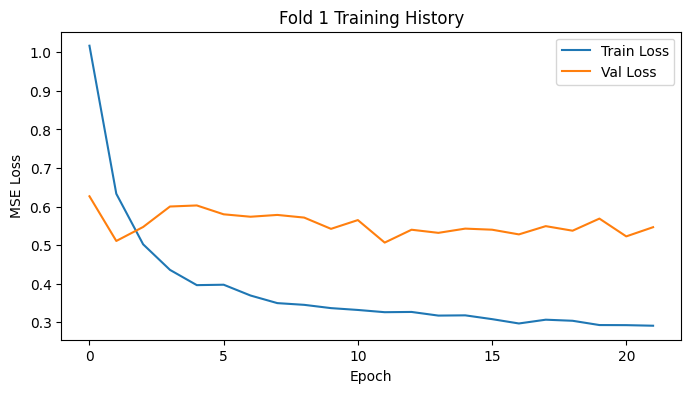


Fold 2...
23/23 [==============================] - 0s 549us/step
Fold 2 -- RMSE: 1.7655, MAE: 1.2385, R²: 0.6485, MAPE: 0.0753


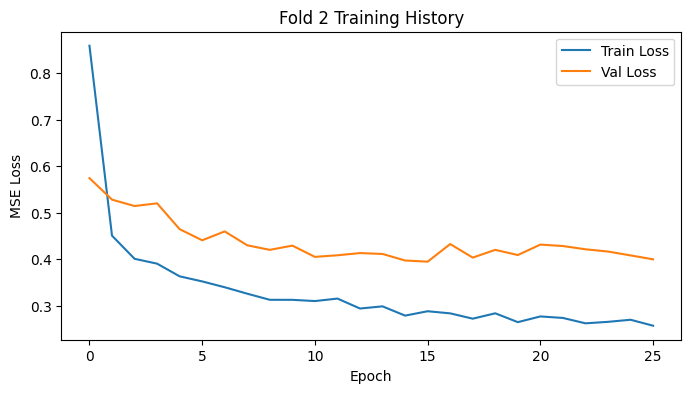


Fold 3...
23/23 [==============================] - 0s 558us/step
Fold 3 -- RMSE: 1.8747, MAE: 1.4444, R²: 0.4988, MAPE: 0.0780


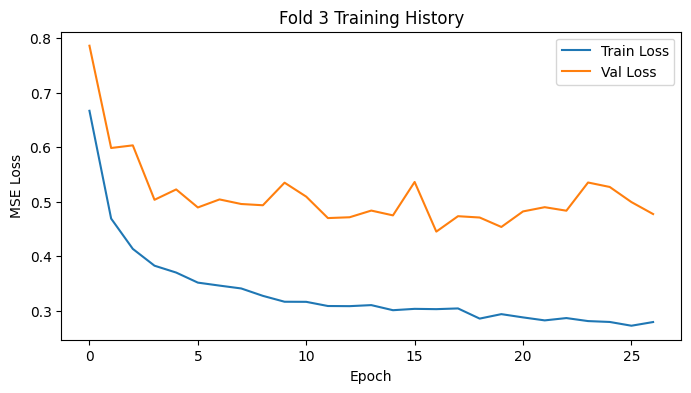


Fold 4...
23/23 [==============================] - 0s 560us/step
Fold 4 -- RMSE: 1.8489, MAE: 1.3322, R²: 0.4423, MAPE: 0.0752


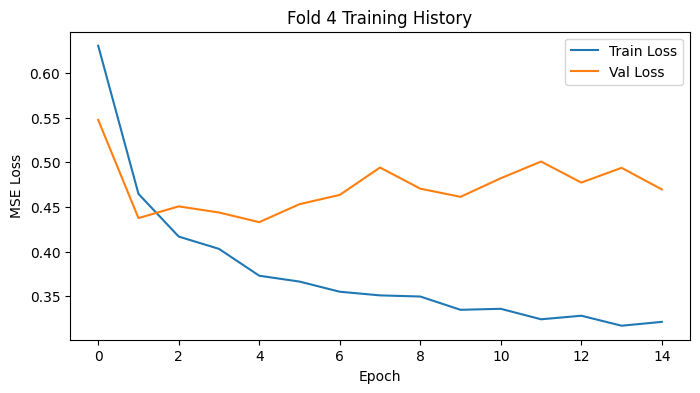


Fold 5...
23/23 [==============================] - 0s 463us/step
Fold 5 -- RMSE: 1.3095, MAE: 1.0243, R²: 0.8153, MAPE: 0.0591


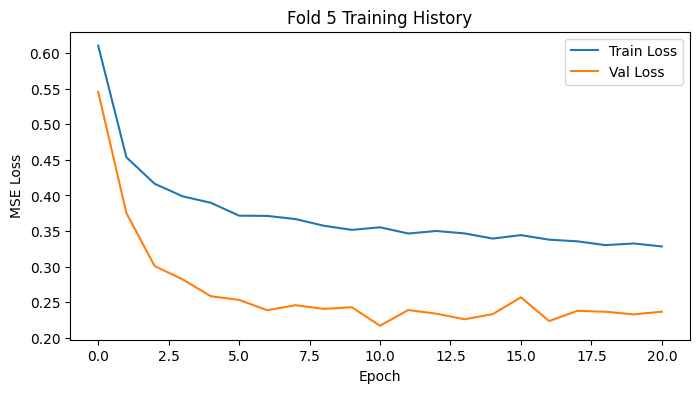

In [9]:
for train_index, val_index in tscv.split(X_scaled):
    print(f"\nFold {fold}...")
    X_train, X_val = X_scaled.iloc[train_index], X_scaled.iloc[val_index]
    y_train, y_val = y_scaled[train_index], y_scaled[val_index]
    
    # Build a new model for this fold
    model = build_nn_model(input_dim=X_train.shape[1])
    
    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stop],
        verbose=0
    )
    
    # Predict on the validation set
    y_val_pred_scaled = model.predict(X_val).flatten()
    y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled.reshape(-1,1)).flatten()
    y_val_orig = scaler_y.inverse_transform(y_val.reshape(-1,1)).flatten()
    
    # Compute evaluation metrics on the original scale
    rmse = np.sqrt(mean_squared_error(y_val_orig, y_val_pred))
    mae = mean_absolute_error(y_val_orig, y_val_pred)
    r2 = r2_score(y_val_orig, y_val_pred)
    mape = mean_absolute_percentage_error(y_val_orig, y_val_pred)
    
    print(f"Fold {fold} -- RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, MAPE: {mape:.4f}")
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)
    mape_list.append(mape)
    
    # (Optional) Plot training history for the current fold
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"Fold {fold} Training History")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.show()
    
    fold += 1

In [10]:
print("\nAverage CV Metrics:")
print(f"Average RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"Average MAE: {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"Average R²: {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")
print(f"Average MAPE: {np.mean(mape_list):.4f} ± {np.std(mape_list):.4f}")


Average CV Metrics:
Average RMSE: 1.7896 ± 0.2267
Average MAE: 1.3696 ± 0.2039
Average R²: 0.5510 ± 0.1382
Average MAPE: 0.0781 ± 0.0108


In [12]:
# Fit final model on entire dataset
final_model = build_nn_model(input_dim=X_scaled.shape[1])
early_stop_final = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
final_history = final_model.fit(
    X_scaled, y_scaled,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop_final],
    verbose=0
)

In [13]:
# Predict on the entire dataset
y_pred_final_scaled = final_model.predict(X_scaled).flatten()
y_pred_final = scaler_y.inverse_transform(y_pred_final_scaled.reshape(-1,1)).flatten()
y_actual = scaler_y.inverse_transform(y_scaled.reshape(-1,1)).flatten()

134/134 [==============================] - 0s 430us/step


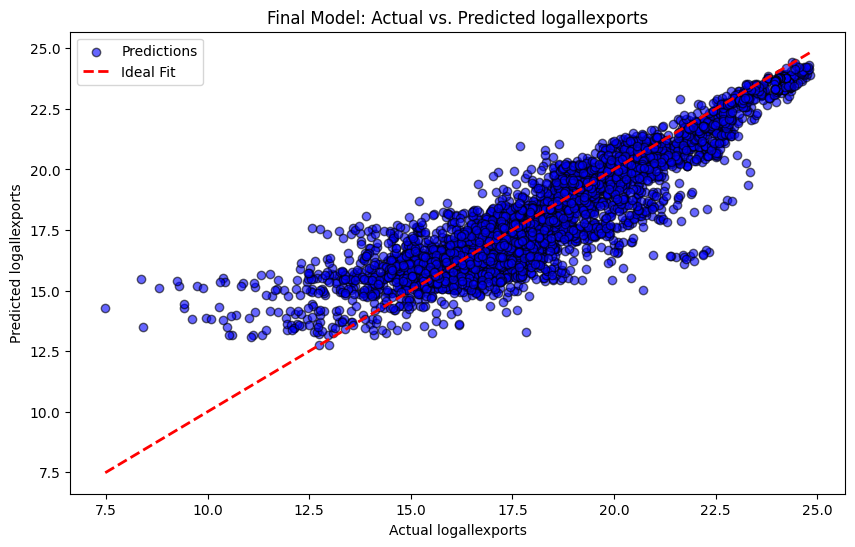

In [14]:
# Plot Actual vs. Predicted for the final model
plt.figure(figsize=(10,6))
plt.scatter(y_actual, y_pred_final, color='blue', alpha=0.6, edgecolor='k', label='Predictions')
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel("Actual logallexports")
plt.ylabel("Predicted logallexports")
plt.title("Final Model: Actual vs. Predicted logallexports")
plt.legend()
plt.show()

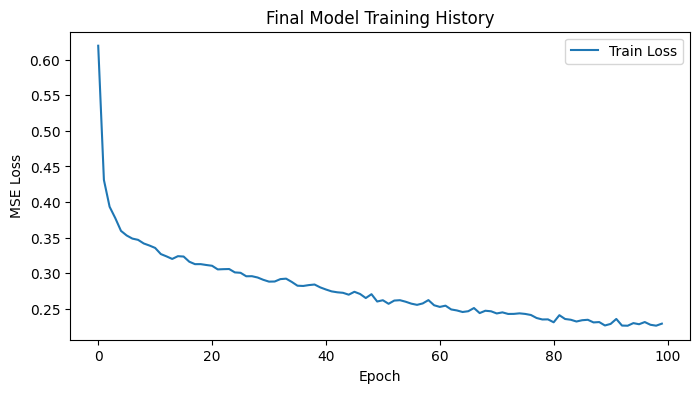

In [15]:
plt.figure(figsize=(8, 4))
plt.plot(final_history.history['loss'], label='Train Loss')
plt.title("Final Model Training History")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()